### Librerias necesarias

%pip install folium 
%pip install geopy
%pip install geopandas
%pip install dash-bootstrap-components
%pip install dash

In [156]:
import mysql.connector
import pandas as pd
import numpy as np
from datetime import datetime
from mysql.connector import errorcode
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker # per poder utilitzar FuncFormatter i aplicar format a la barra
from matplotlib.ticker import FuncFormatter # per poder utilitzar el separador de milersimport geopandas as gpd
from geopy.geocoders import Nominatim
import geopandas as gpd
from shapely.geometry import Point
import time
from geopy.exc import GeocoderTimedOut
import folium
from folium.plugins import MarkerCluster


### Conexion a MySQL para extraer tabla

In [157]:
try:
    # Intentar conectar a la base de datos
    cnx = mysql.connector.connect(
        user='EquipoG',
        password='E1q2u3i4p5oG',
        database='Equip_G',
        host='212.227.90.6',
        charset='utf8mb4'
    )
    mycursor = cnx.cursor()  # Crear cursor

    # Nombre de la tabla a extraer
    tabla = "Tourist_Accommodation"

    # Ejecutar consulta para obtener los datos
    mycursor.execute(f"SELECT * FROM {tabla}")
    columnas = [desc[0] for desc in mycursor.description]  # Obtener nombres de columnas
    datos = mycursor.fetchall()  # Obtener datos

    # Crear DataFrame
    df = pd.DataFrame(datos, columns=columnas)

    # Imprimir los primeros registros
    print(df.head())

except mysql.connector.Error as err:
    # Manejo de errores específicos
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Usuario o contraseña incorrectos")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("La base de datos especificada no existe")
    else:
        print(f"Error inesperado: {err}")

finally:
    # Cerrar conexión
    try:
        if 'mycursor' in locals() and mycursor:
            mycursor.close()
        if 'cnx' in locals() and cnx.is_connected():
            cnx.close()
    except Exception as e:
        print(f"Error al cerrar la conexión: {e}")

   apartment_id                                               name  \
0         11964                                 A ROOM WITH A VIEW   
1         21853                               Bright and airy room   
2         32347  Explore Cultural Sights from a Family-Friendly...   
3         35379                  Double 02 CasanovaRooms Barcelona   
4         35801                  Can Torras Farmhouse Studio Suite   

                                         description  host_id  \
0  Private bedroom in our attic apartment. Right ...    45553   
1  We have a quiet and sunny room with a good vie...    83531   
2  Open French doors and step onto a plant-filled...   139939   
3  Room at a my apartment. Kitchen and 2 bathroom...   152232   
4  Lay in bed & watch sunlight change the mood of...   153805   

                neighbourhood_name neighbourhood_district        room_type  \
0                           Centro                   None     Private room   
1                         C�rmen

## Trabajo en Pandas

### Comprobar dataset

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7001 entries, 0 to 7000
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   apartment_id                 7001 non-null   int64  
 1   name                         6998 non-null   object 
 2   description                  6972 non-null   object 
 3   host_id                      7001 non-null   int64  
 4   neighbourhood_name           7001 non-null   object 
 5   neighbourhood_district       4241 non-null   object 
 6   room_type                    7001 non-null   object 
 7   accommodates                 7001 non-null   int64  
 8   bathrooms                    6969 non-null   object 
 9   bedrooms                     6972 non-null   object 
 10  beds                         6998 non-null   float64
 11  amenities_list               6984 non-null   object 
 12  price                        6870 non-null   float64
 13  minimum_nights    

### Cambio de tipo de datos de fechas

In [159]:
df['first_review_date'] = pd.to_datetime(df['first_review_date'], format='%d/%m/%Y')
df['insert_date'] = pd.to_datetime(df['insert_date'], format='%d/%m/%Y')
df['last_review_date'] = pd.to_datetime(df['last_review_date'], format='%d/%m/%Y')

### Funcion para borrar duplicados basados en la fecha mas reciente

In [160]:
def mantener_fecha_mas_reciente(df, columna_id, columna_fecha):
    """
    Elimina duplicados basados en un ID, manteniendo la fila con la fecha más reciente.
    
    Parámetros:
    df (DataFrame): El DataFrame que contiene los datos.
    columna_id (str): El nombre de la columna que identifica los duplicados.
    columna_fecha (str): El nombre de la columna que contiene las fechas.

    Retorna:
    DataFrame: Un nuevo DataFrame con los IDs únicos y sus fechas más recientes.
    """

    # Ordenar por fecha descendente
    df = df.sort_values(by=columna_fecha, ascending=False)

    # Eliminar duplicados manteniendo el más reciente
    df = df.drop_duplicates(subset=columna_id, keep='last')

    return df



#### Numero de registros duplicados

In [161]:
total_registros = len(df)
valores_unicos = df['apartment_id'].nunique()
duplicados = total_registros - valores_unicos
print(f"Registros duplicados: {duplicados}")
print(f"Registros que deberían quedar: {valores_unicos}")

Registros duplicados: 268
Registros que deberían quedar: 6733


### Ejecutar funcion al dataset con el ID del apartamento y la fecha de insersion 

In [162]:
df = mantener_fecha_mas_reciente(df, columna_id='apartment_id', columna_fecha='insert_date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6733 entries, 4067 to 2456
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 6733 non-null   int64         
 1   name                         6730 non-null   object        
 2   description                  6706 non-null   object        
 3   host_id                      6733 non-null   int64         
 4   neighbourhood_name           6733 non-null   object        
 5   neighbourhood_district       4075 non-null   object        
 6   room_type                    6733 non-null   object        
 7   accommodates                 6733 non-null   int64         
 8   bathrooms                    6706 non-null   object        
 9   bedrooms                     6706 non-null   object        
 10  beds                         6730 non-null   float64       
 11  amenities_list               6716 non-null   

### Normalizacion de "Amenities"

#### Diccionario de equivalencias 

In [163]:
equivalencias = {
    # Categoría: Conectividad
    "wifi": ["wifi", "wi-fi", "wireless connection", "wireless internet", "wifi – 100 mbps", "pocket wifi"],
    
    # Categoría: Entretenimiento
    "tv": ["tv", "television", "cable tv", "smart tv", "netflix", "43 hdtv with netflix", "dvd player"],
    
    # Categoría: Climatización
    "air conditioning": ["air conditioning", "ac", "central air conditioning", "ceiling fan"],
    "heating": ["heating", "central heating"],

    # Categoría: Cocina
    "nespresso machine": ["nespresso machine", "espresso machine", "coffee maker", "pour-over coffee", "pour over coffee"],
    "oven": ["oven", "convection oven", "stainless steel oven", "double oven"],
    "stove": ["stove", "electric stove", "gas oven", "stainless steel stove"],
    "toaster": ["toaster", "bread maker"],
    "baking sheet": ["baking sheet"],
    "dishwasher": ["dishwasher"],
    "kitchen": ["kitchen", "full kitchen", "chef's kitchen", "kitchenette", "cooking basics"],
    "microwave": ["microwave", "microwave oven"],

    # Categoría: Habitaciones y camas
    "bed linens": ["bed linens", "extra pillows and blankets", "memory foam mattress", "pillow-top mattress", "firm mattress"],
    "crib": ["crib", "pack u2019n play/travel crib", "pack 'n play/travel crib"],

    # Categoría: Baños
    "bathtub": ["bathtub", "soaking tub", "hot tub"],
    "shower": ["roll-in shower", "rain shower", "shower chair", "step-free shower", "handheld shower head"],
    "bathroom essentials": ["toilet paper", "conditioner", "shampoo", "body soap", "bathroom essentials"],
    "hot water": ["hot water", "hot water kettle"],

    # Categoría: Accesibilidad
    "wheelchair accessible": ["wheelchair accessible", "flat path to guest entrance", "no stairs or steps to enter", "step-free access"],
    "wide clearance": ["wide clearance to shower & toilet", "wide clearance to bed", "wide doorway", "wide hallways"],
    "accessible-height bed": ["accessible-height bed", "accessible-height toilet"],

    # Categoría: Exterior
    "balcony": ["balcony", "patio or balcony"],
    "garden or backyard": ["garden or backyard", "shared garden or backyard"],
    "outdoor seating": ["outdoor seating", "terrace", "bbq grill"],
    "beachfront": ["beachfront", "beach essentials", "waterfront"],

    # Categoría: Niños y familia
    "children's amenities": ["children s books and toys", "children s dinnerware", "baby bath", "changing table", "stair gates", "table corner guards"],
    "high chair": ["high chair"],

    # Categoría: Seguridad
    "fire safety": ["fire extinguisher", "smoke alarm", "carbon monoxide alarm", "carbon monoxide detector", "fireplace guards"],
    "security system": ["security system"],

    # Categoría: Gimnasio y lujo
    "gym": ["gym", "exercise equipment"],
    "bluetooth sound system": ["bluetooth sound system", "sound system"],
    "heated towel rack": ["heated towel rack"],
    "wine glasses": ["wine glasses"],

    # Categoría: Estacionamiento
    "free parking": ["free parking on premises", "free parking on street", "free street parking"],
    "paid parking": ["paid parking on premises", "paid parking off premises", "paid parking garage"],

    # Categoría: Otros
    "iron": ["iron", "ironing board"],
    "workspace": ["dedicated workspace", "laptop-friendly workspace", "office", "printer"],
    "lockbox": ["lockbox"],
    "hangers": ["hangers"]
}
# Se puede actualizar el diccionario, segun se ingresen mas caracteristicas 



#### Funcion que normaliza las amenities


In [164]:
def normalizar_amenities(amenities, equivalencias):
    if not amenities:  # Si 'amenities' es None o está vacío
        return ''  # Retornamos un string vacío
    normalized = set()  # Usamos un conjunto para evitar duplicados
    for amenity in amenities.split(','):  # Dividimos por comas las amenidades
        matched = False
        for key, synonyms in equivalencias.items():
            for synonym in synonyms:
                if synonym.lower() in amenity.lower().strip():
                    normalized.add(key)
                    matched = True
                    break
        if not matched:  # Si no coincide con ninguna clave del diccionario
            normalized.add(amenity.lower().strip())  # Agregamos la amenidad como está
    return ', '.join(normalized)  # Retornamos las amenidades normalizadas

#### Normalizamos las amenities y creamos una nueva columna con las amenities normalizadas 

In [165]:
# Aplicamos la función a la columna 'amenities'
df['normalized_amenities'] = df['amenities_list'].apply(lambda x: normalizar_amenities(x, equivalencias))

# Mostramos el resultado
df[['normalized_amenities', 'amenities_list']].head()

,normalized_amenities,amenities_list
4067,"nespresso machine, oven, elevator, microwave, ...","Cooking basics, Hair dryer, Heating, TV, Bed l..."
5294,"toaster, long term stays allowed, tv, bed line...","Essentials, Kitchen, Hair dryer, Bed linens, T..."
461,"nespresso machine, oven, bathroom essentials, ...","Waterfront, Pack u2019n Play/travel crib, Pati..."
5637,"nespresso machine, bathroom essentials, elevat...","Bathtub, Free parking on premises, Free street..."
5078,"paid parking, bathroom essentials, elevator, e...","Lockbox, Air conditioning, Carbon monoxide ala..."


#### Mostrar la diferencia entre amenities unicas con y sin normalizar

In [166]:
# Extraer las amenidades originales únicas
amenidades_originales = set()
df['amenities_list'].dropna().apply(lambda x: [amenidades_originales.add(i.strip().lower()) for i in x.split(',')])

# Extraer las amenidades normalizadas únicas
amenidades_normalizadas = set()
df['normalized_amenities'].dropna().apply(lambda x: [amenidades_normalizadas.add(i.strip().lower()) for i in x.split(',')])

# Mostrar las amenidades únicas
print("Amenidades originales únicas:", len(amenidades_originales))
print("Amenidades normalizadas únicas:", len(amenidades_normalizadas))

Amenidades originales únicas: 308
Amenidades normalizadas únicas: 180


### Imputamos valor a los precios nulos

#### Exploración de los precios.

In [167]:
df[['apartment_id','price']].describe()

,apartment_id,price
count,6.733000e+03,6613.000000
mean,1.512717e+07,1009.924996
std,7.729288e+06,845.926762
min,1.196400e+04,60.000000
25%,8.699662e+06,450.000000
50%,1.677280e+07,750.000000
75%,2.148062e+07,1220.000000
max,2.724512e+07,6071.000000


Tenemos los precios de 6613 de los 6733 apartementos regristrados, con lo que 120 registros no tienen precio. O bien, lo que vendría siendo el 1.78% de los registros.

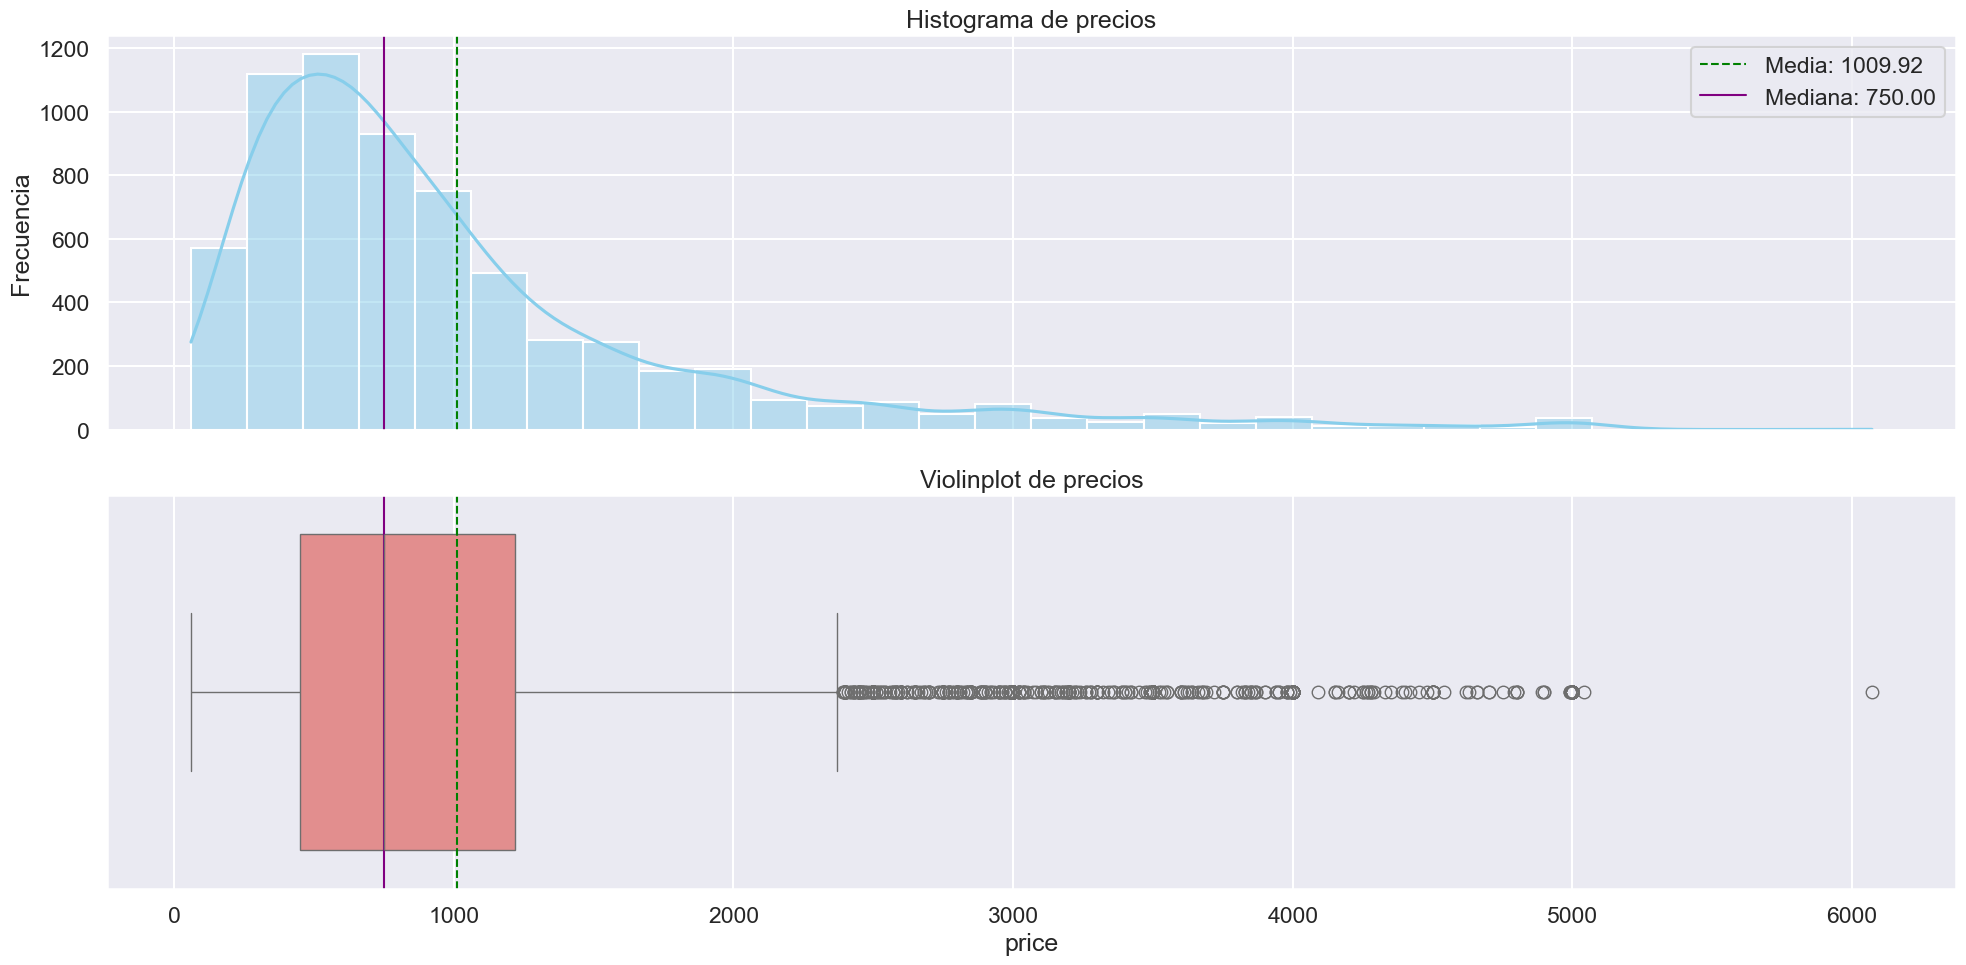

In [168]:
media_precio = df['price'].mean()
mediana_precio = df['price'].median()

sns.set_theme(context='talk', style='darkgrid')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), sharex=True)

sns.histplot(df['price'].dropna(), bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].axvline(media_precio, color='green', linestyle='--', linewidth=1.5, label=f'Media: {media_precio:.2f}')
axes[0].axvline(mediana_precio, color='purple', linestyle='-', linewidth=1.5, label=f'Mediana: {mediana_precio:.2f}')
axes[0].set_title('Histograma de precios')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

sns.boxplot(x=df['price'].dropna(), ax=axes[1], color='lightcoral')
axes[1].axvline(media_precio, color='green', linestyle='--', linewidth=1.5)
axes[1].axvline(mediana_precio, color='purple', linestyle='-', linewidth=1.5)
axes[1].set_title('Violinplot de precios')

plt.tight_layout()
plt.show()

Insights:
* Vemos que la distribución es asimétrica, con una cola larga de outliers a la derecha y con la mayoría de los precios hacia la izquierda. 
* Los outliers son de precios altos, más allá de 3.000 € y hasta 6.000 €.
* La mediana (750 €) está por debajo de la media (1009,92 €), lo cual confirma el sesgo positivo.

#### Imputación
En este contexto, imputar por la media no sería lo ideal porque se vería muy influenciada por outliers.   
Por lo que optamos por imputar usando la mediana por ciudad, tipo de habitación y accomodates. Esto es simple pero efectivo.

In [169]:
# Imputar mediana por grupos especificos.
df['price'] = df.groupby(['city', 'room_type', 'accommodates'])['price'].transform(
    lambda x: x.fillna(x.median()))

In [170]:
print(f'Hay {df["price"].isnull().sum()} precios con valores nulos')

Hay 6 precios con valores nulos


In [171]:
# Imputar mediana por grupos más generales.
df['price'] = df.groupby(['city', 'room_type'])['price'].transform(
    lambda x: x.fillna(x.median()))

La primera ejecucion del código resulto en grupos que seguían teniedo valores nulos en 6 registros, por eso agregamos una segunda parte con un grupo más general para estos casos (sin tomar en cuenta los 'accommodates', solo ciudad y tipo de habitacion).

#### Comprobación rápida.

In [172]:
print(f"Hay {df['price'].isnull().sum()} precios con valores nulos")

Hay 0 precios con valores nulos


### EDA's 

#### EDA Operaciones

##### Funciones 

Función de generación de gráficos EDA Operaciones

In [173]:
def generar_graficos_disponibilidad(df):
    
    # Calcular la media de disponibilidad por ciudad
    disponibilidad_media = df.groupby('city')[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean()

    # Calcular el porcentaje de disponibilidad respecto al total de días posibles (30, 60, 90, 365)
    disponibilidad_media_porcentaje = disponibilidad_media.copy()

    # Calcular el porcentaje para cada columna de disponibilidad
    disponibilidad_media_porcentaje['availability_30'] = (disponibilidad_media['availability_30'] / 30) * 100
    disponibilidad_media_porcentaje['availability_60'] = (disponibilidad_media['availability_60'] / 60) * 100
    disponibilidad_media_porcentaje['availability_90'] = (disponibilidad_media['availability_90'] / 90) * 100
    disponibilidad_media_porcentaje['availability_365'] = (disponibilidad_media['availability_365'] / 365) * 100

    # Definir una paleta de colores coherente y con buen contraste para los gráficos
    colores = sns.color_palette("Set2", 4)  # Usamos una paleta de colores más saturados y contrastantes

    # Mostrar la media de disponibilidad por ciudad
    print("Media de disponibilidad por ciudad\n")
    print(disponibilidad_media)

    # Mostrar la media de disponibilidad en porcentaje por ciudad
    print("\nMedia de disponibilidad en porcentaje por ciudad\n")
    print(disponibilidad_media_porcentaje)

Funcion de distribución de la disponibilidad en los distintos períodos boxplot

In [174]:
def distribucion_disponibilidadboxplot(df, colores):
    # Crear la figura y la cuadrícula de subgráficos (2x2)
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))  # 2 filas, 2 columnas
    
    # Lista de períodos de disponibilidad
    periodos = ['30', '60', '90', '365']
    disponibilidades = [df['availability_30'], df['availability_60'], df['availability_90'], df['availability_365']]
    
    for i, (periodo, disponibilidad) in enumerate(zip(periodos, disponibilidades)):
        fila = i // 2  # 0 o 1 (primera o segunda fila)
        columna = i % 2  # 0 o 1 (primera o segunda columna)
        
        # Seleccionar el eje correspondiente en la cuadrícula
        sns.boxplot(data=disponibilidad, color=colores[i], ax=ax[fila, columna])
        
        # Añadir título y etiquetas
        ax[fila, columna].set_title(f'Distribución de la Disponibilidad en los Últimos {periodo} Días', fontsize=12)
        ax[fila, columna].set_xlabel(f'Días Disponibles (Últimos {periodo} días)', fontsize=10)
        ax[fila, columna].set_ylabel('Días Disponibles', fontsize=10)
    
    # Ajustar el diseño para una mejor visualización
    plt.tight_layout()
    plt.show()

Funcion de  distribución de la disponibilidad en los distintos períodos barras

In [175]:
def distribucion_disponibilidadbarras(df, colores):
    # Crear la figura y la cuadrícula de subgráficos (2x2)
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))  # 2 filas, 2 columnas
    
    # Lista de períodos de disponibilidad
    periodos = ['30', '60', '90', '365']
    disponibilidades = [df['availability_30'], df['availability_60'], df['availability_90'], df['availability_365']]
    
    for i, (periodo, disponibilidad) in enumerate(zip(periodos, disponibilidades)):
        fila = i // 2  # 0 o 1 (primera o segunda fila)
        columna = i % 2  # 0 o 1 (primera o segunda columna)
        
        # Seleccionar el eje correspondiente en la cuadrícula
        sns.histplot(disponibilidad, kde=True, color=colores[i], bins=30, ax=ax[fila, columna])
        
        # Añadir título y etiquetas
        ax[fila, columna].set_title(f'Distribución de la Disponibilidad en los Últimos {periodo} Días', fontsize=12)
        ax[fila, columna].set_xlabel(f'Días Disponibles (Últimos {periodo} días)', fontsize=10)
        ax[fila, columna].set_ylabel('Frecuencia', fontsize=10)
    
    # Ajustar el diseño para una mejor visualización
    plt.tight_layout()
    plt.show()

Funcion de mini gráficos para cada categoría de disponibilidad

In [176]:
def mini_graficos_categoria(disponibilidad_media, colores):
    # Segunda parte: Mini gráficos para cada categoría de disponibilidad (sin porcentajes)
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))  # 2 filas, 2 columnas

    # Lista de categorías
    categorias = ['availability_30', 'availability_60', 'availability_90', 'availability_365']

    for i, categoria in enumerate(categorias):
        fila = i // 2  # 0 o 1 (primera o segunda fila)
        columna = i % 2  # 0 o 1 (primera o segunda columna)

        ax_sub = ax[fila, columna]
        # Para cada categoría, mostrar la disponibilidad media sin porcentajes
        disponibilidad_media[categoria].plot(kind='bar', ax=ax_sub, width=0.8, color=colores[i])

        ax_sub.set_title(f'Disponibilidad Media {categoria}', fontsize=12)
        ax_sub.set_xlabel('Ciudad', fontsize=10)
        ax_sub.set_ylabel(f'Media {categoria}', fontsize=10)
        ax_sub.set_xticklabels(disponibilidad_media.index, rotation=45, ha='right')

    # Ajustar el diseño para una mejor visualización
    plt.tight_layout()
    plt.show()

Funcion para cada ciudad con disponibilidad media en porcentaje

In [177]:
def graficos_por_ciudad(disponibilidad_media_porcentaje, colores):
    # Tercera parte: Gráficos de barras para cada ciudad con la disponibilidad media en porcentaje
    
    # Determinar el número de filas y columnas en la cuadrícula (4x4)
    num_ciudades = len(disponibilidad_media_porcentaje)
    filas = 2
    columnas = 4
    
    # Crear la figura y la cuadrícula de subgráficos
    fig, ax = plt.subplots(filas, columnas, figsize=(20, 10))  # Ajustamos el tamaño de la figura
    
    # Convertir la matriz de ejes en una lista para poder iterar sobre ella
    ax = ax.flatten()
    
    for i, ciudad in enumerate(disponibilidad_media_porcentaje.index):
        # Extraer los valores de disponibilidad para la ciudad
        ciudad_data = disponibilidad_media_porcentaje.loc[ciudad]

        # Seleccionar el eje correspondiente en la cuadrícula
        ax[i].bar(ciudad_data.index, ciudad_data.values, color=colores, width=0.8)

        # Añadir título y etiquetas
        ax[i].set_title(f'Disponibilidad Media (%)\npor Ciudad: {ciudad}', fontsize=12)
        ax[i].set_xlabel('Periodo (días)', fontsize=10)
        ax[i].set_ylabel('Disponibilidad Media (%)', fontsize=10)

        # Ajustar las etiquetas del eje X automáticamente
        ax[i].tick_params(axis='x', rotation=45)

        # Establecer los límites de los ejes
        ax[i].set_ylim(0, 100)  # Limitar el eje Y de 0 a 100
        ax[i].set_xlim(-0.5, 3.5)  # Limitar el eje X de 0 a 3 (porque tenemos 4 barras)

    # Ajustar el diseño para una mejor visualización
    plt.tight_layout()
    plt.show()

Funcion de las medias de todas las ciudades

In [178]:
def grafico_media_todas_las_ciudades(disponibilidad_media_porcentaje, colores):
    # Última parte: Gráfico de las medias de todas las ciudades
    plt.figure(figsize=(12, 8))
    disponibilidad_media_porcentaje.plot(kind='bar', figsize=(12, 8), color=colores)
    plt.title('Disponibilidad Media (%) de los Alojamientos Turísticos por Ciudad')
    plt.xlabel('Ciudad')
    plt.ylabel('Disponibilidad Media (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### Graficos

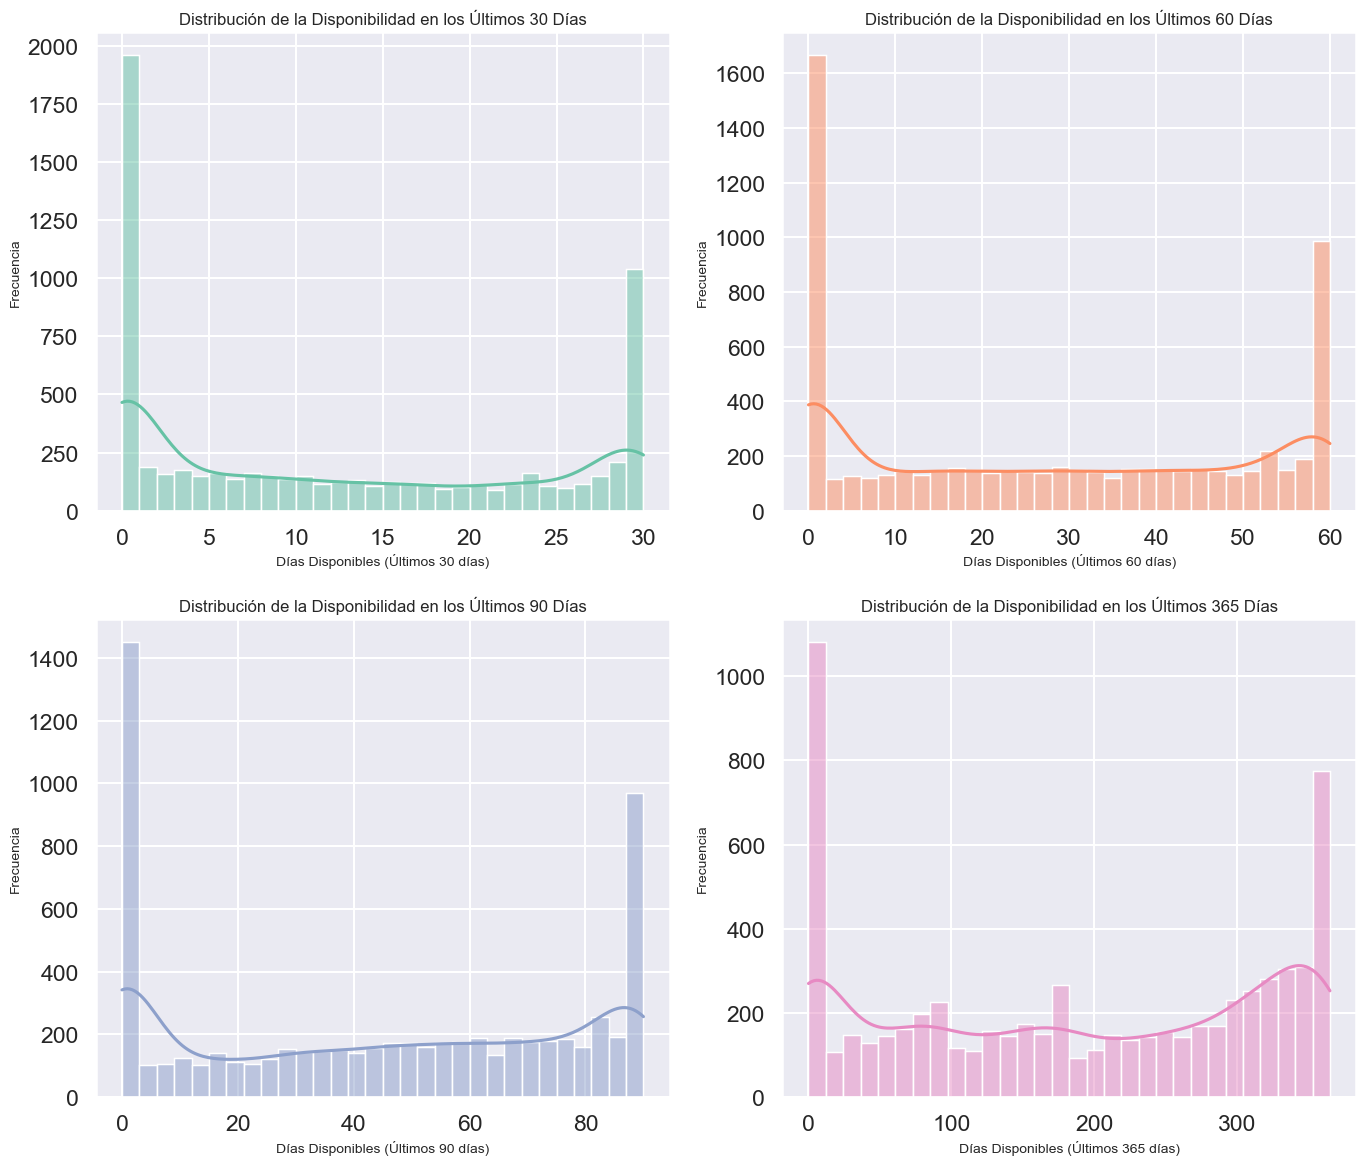

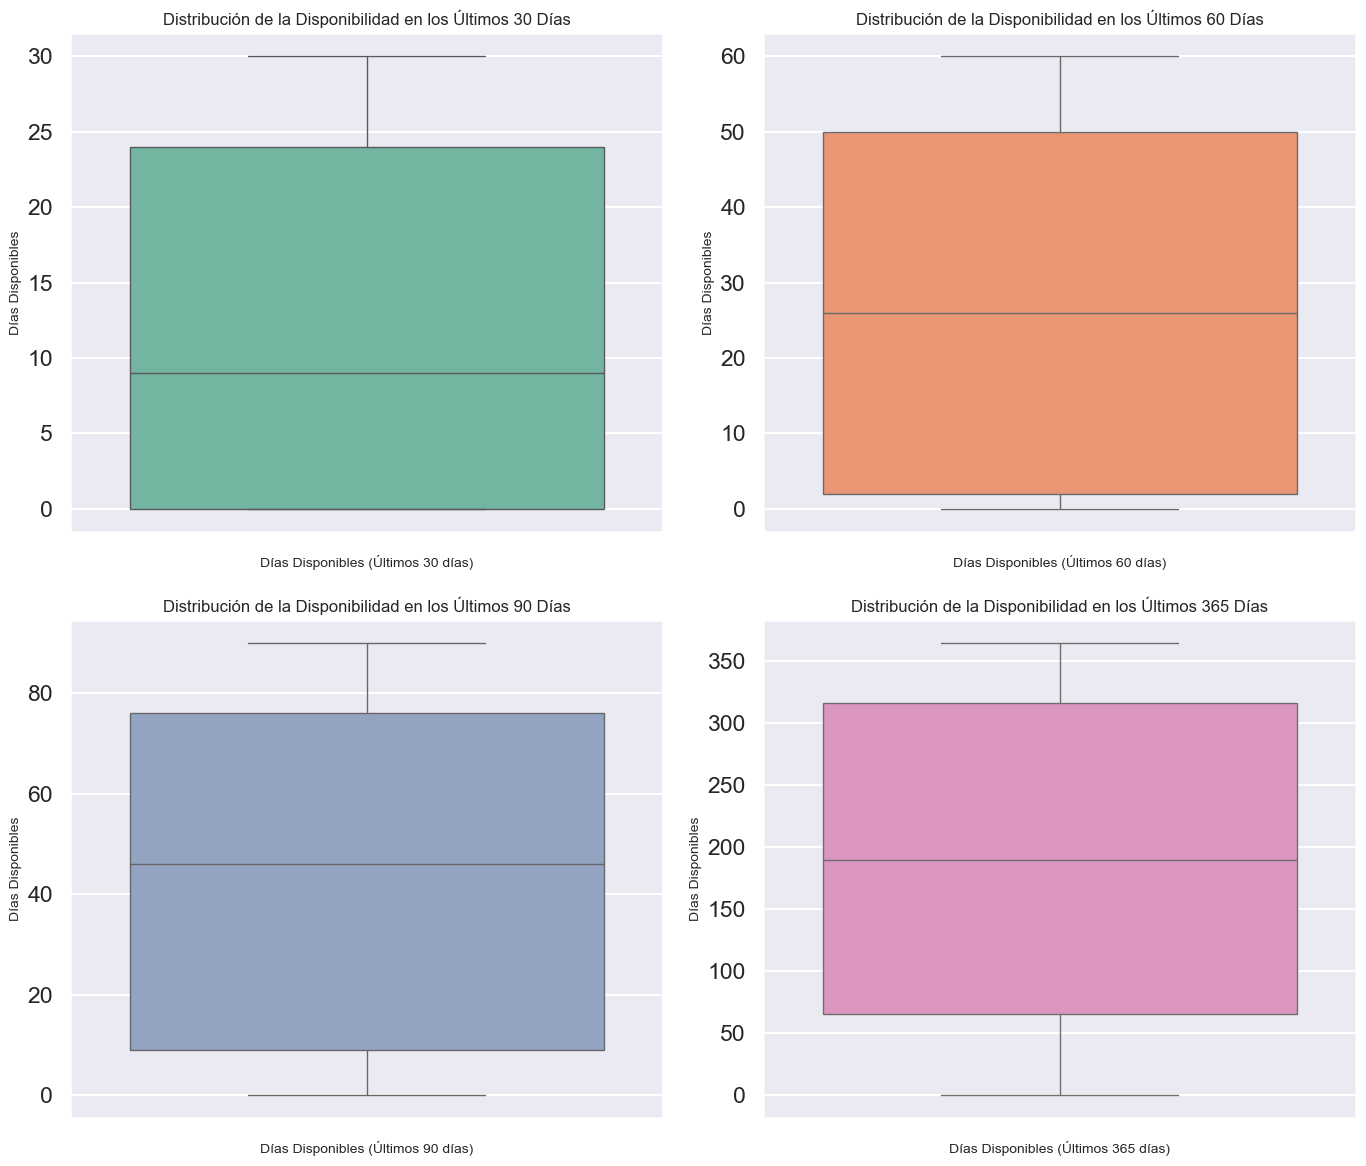

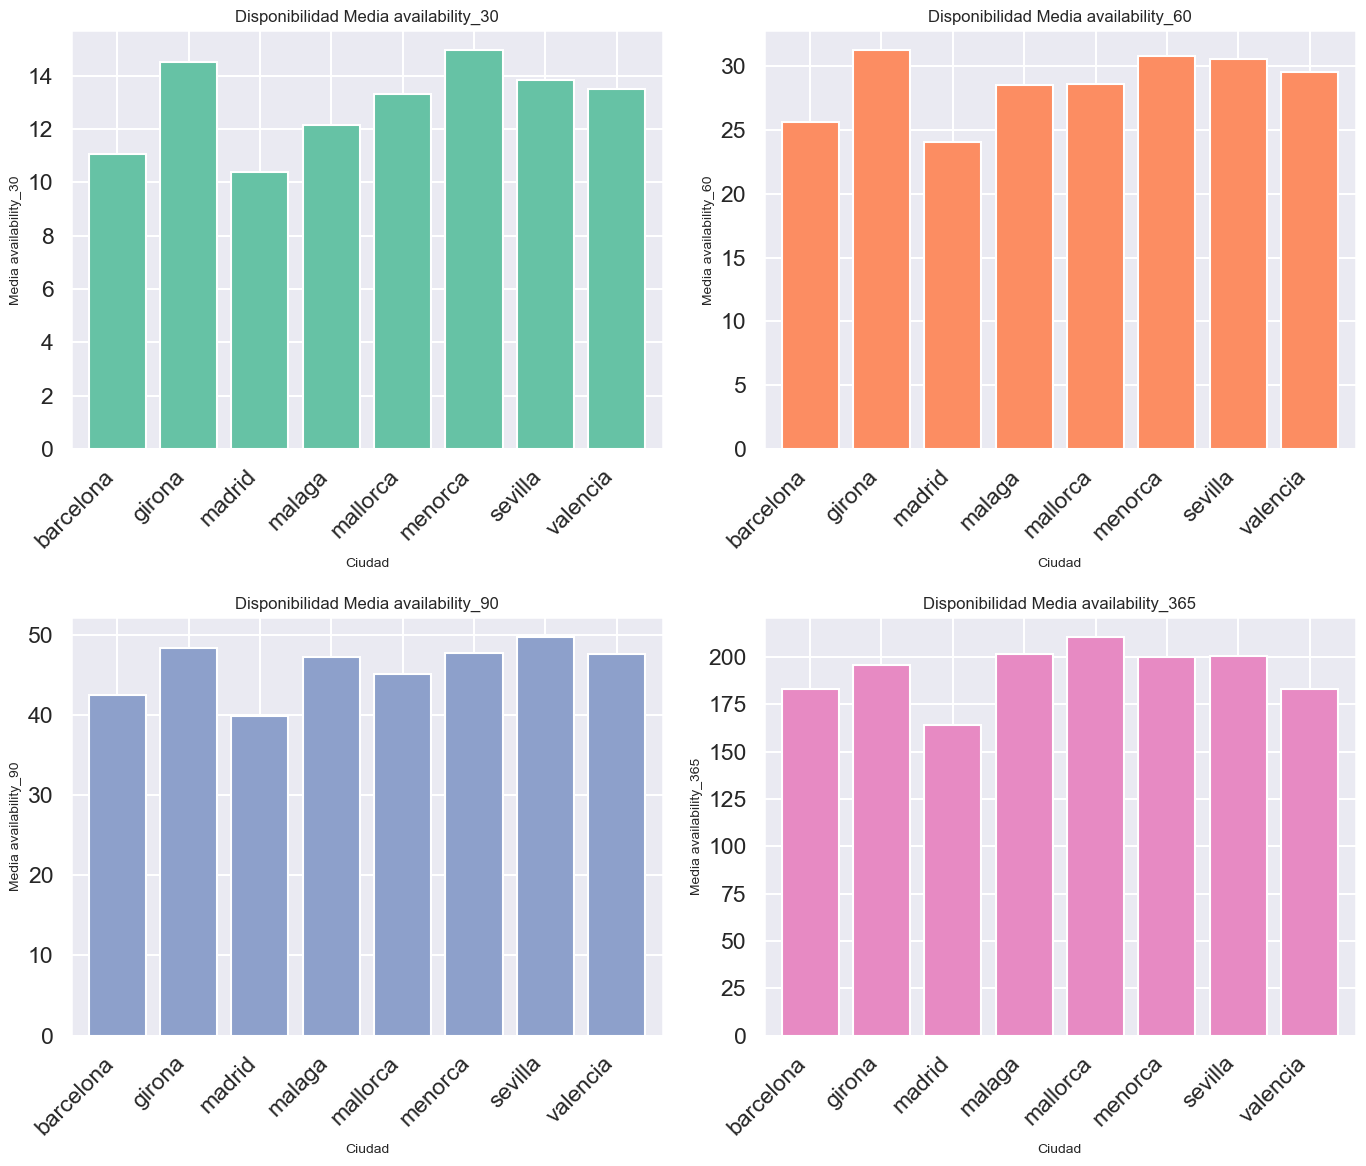

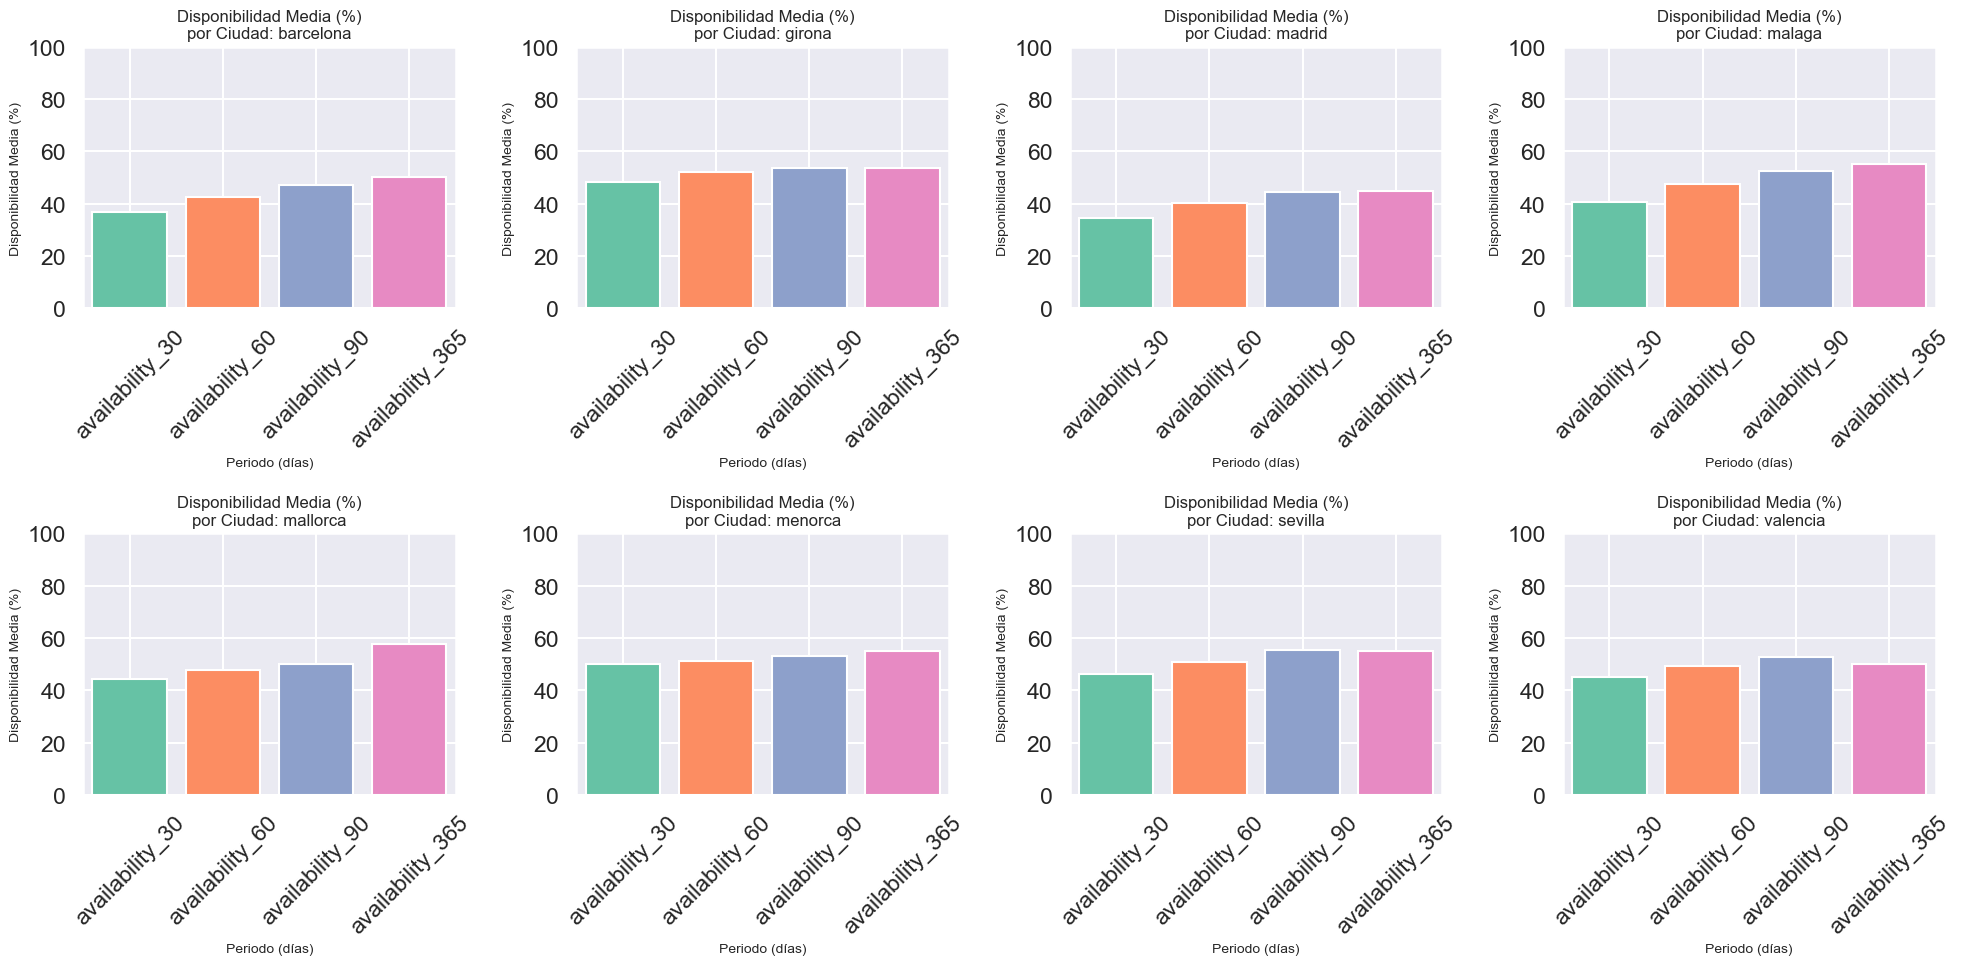

<Figure size 1200x800 with 0 Axes>

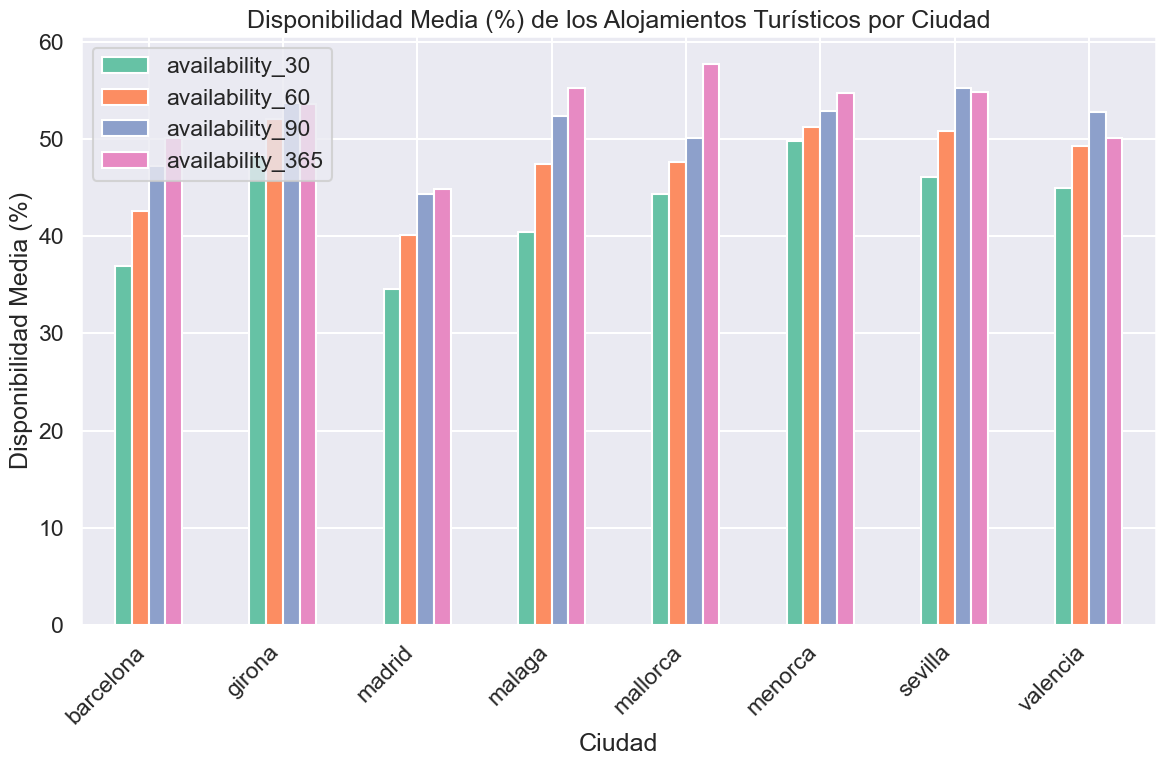

In [179]:
# Primero, calcular los porcentajes y la media
disponibilidad_media = df.groupby('city')[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean()
disponibilidad_media_porcentaje = disponibilidad_media.copy()

# Calcular los porcentajes para cada columna
disponibilidad_media_porcentaje['availability_30'] = (disponibilidad_media['availability_30'] / 30) * 100
disponibilidad_media_porcentaje['availability_60'] = (disponibilidad_media['availability_60'] / 60) * 100
disponibilidad_media_porcentaje['availability_90'] = (disponibilidad_media['availability_90'] / 90) * 100
disponibilidad_media_porcentaje['availability_365'] = (disponibilidad_media['availability_365'] / 365) * 100

# Definir la paleta de colores
colores = sns.color_palette("Set2", 4)

# Llamar las funciones para generar los gráficos
distribucion_disponibilidadbarras(df, colores)
distribucion_disponibilidadboxplot(df, colores)
mini_graficos_categoria(disponibilidad_media, colores)
graficos_por_ciudad(disponibilidad_media_porcentaje, colores)
grafico_media_todas_las_ciudades(disponibilidad_media_porcentaje, colores)

### EDA Clientes

#### Exploracion

In [180]:
df[['apartment_id', 'first_review_date', 'last_review_date',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month','city']].describe(include='all')

,apartment_id,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,city
count,6.733000e+03,5516,5515,5446.000000,5437.000000,5443.000000,5432.000000,5441.000000,5431.000000,5431.000000,5516.000000,6733
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,barcelona
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2041
mean,1.512717e+07,2016-11-17 05:55:02.393038592,2018-10-14 19:34:42.973708032,920.104664,94.539268,93.161859,96.277614,96.432641,95.273430,91.461978,122.733684,NaN
min,1.196400e+04,2010-01-02 00:00:00,2012-11-17 00:00:00,200.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,1.000000,NaN
25%,8.699662e+06,2016-01-05 00:00:00,2018-01-30 12:00:00,890.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,17.000000,NaN
50%,1.677280e+07,2017-03-20 00:00:00,2018-10-19 00:00:00,940.000000,100.000000,100.000000,100.000000,100.000000,100.000000,90.000000,56.000000,NaN
75%,2.148062e+07,2018-02-03 06:00:00,2019-08-30 00:00:00,980.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,176.000000,NaN
max,2.724512e+07,2020-10-24 00:00:00,2021-02-13 00:00:00,1000.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1291.000000,NaN


#### Imputamos fecha de inserción del registro para los casos en que hay reseñas y la last_review_date es nula

In [181]:
df.loc[df['last_review_date'].isna() & df['first_review_date'].notna(), 'last_review_date'] = df['insert_date']

Text(0.5, 0, 'N.º de reseñas')

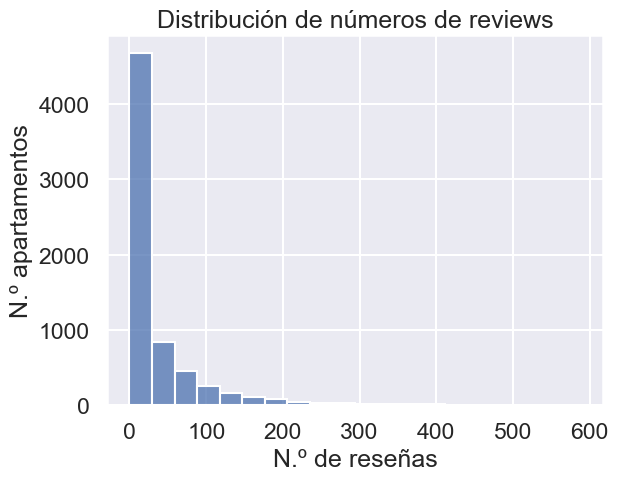

In [182]:
ax = sns.histplot(data=df, x='number_of_reviews', bins=20)
ax.set_title("Distribución de números de reviews")
ax.set_ylabel("N.º apartamentos")
ax.set_xlabel("N.º de reseñas")

Text(0.5, 0.98, 'Kde de distribución de reviews')

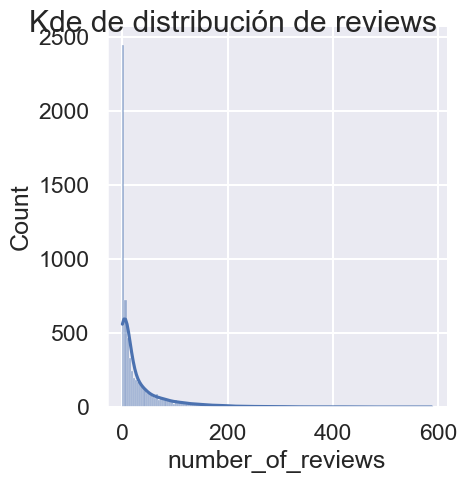

In [183]:
ax = sns.displot(data=df, x='number_of_reviews', kde=True)
ax.figure.suptitle("Kde de distribución de reviews")

Text(0.5, 1.0, 'Distribución estadística del rating total por ciudad')

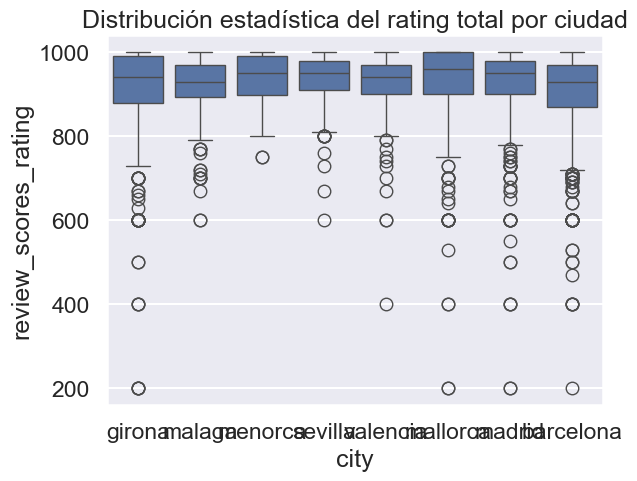

In [184]:
ax = sns.boxplot(data=df, x='city', y='review_scores_rating')
ax.set_title("Distribución estadística del rating total por ciudad")

### EDA Marketing y comunicacion

#### Funciones


##### Función para añadir el símbolo € a los valores del eje

In [185]:
def euro_formatter(x, pos):
    return f"{x:,.0f}€"  # Format amb 0 

##### Función para formatear el eje y con separador de miles

In [186]:
def formato_miles(x, pos):
    return f'{int(x):,}'

##### Establecer paleta y estilo

In [187]:
sns.set_style("darkgrid")
sns.set_palette("tab10") 

#### 002 Análisis Descriptivo
    Resumen descriptivo de los datos

for table_name, df in df.items():
    print(f"Head of {table_name}:")
    print(df.head())
    print("\n")

##### 002-1 Para variables numéricas

In [188]:
print(df.describe()) 

       apartment_id       host_id  accommodates         beds        price  \
count  6.733000e+03  6.733000e+03   6733.000000  6730.000000  6733.000000   
mean   1.512717e+07  6.244597e+07      4.346502     3.013670  1027.125947   
min    1.196400e+04  1.070400e+04      1.000000     0.000000    60.000000   
25%    8.699662e+06  1.054730e+07      2.000000     1.000000   460.000000   
50%    1.677280e+07  4.303165e+07      4.000000     2.000000   750.000000   
75%    2.148062e+07  1.066987e+08      6.000000     4.000000  1250.000000   
max    2.724512e+07  3.365242e+08     29.000000    30.000000  6071.000000   
std    7.729288e+06  5.755268e+07      2.627289     2.339347   858.756014   

       minimum_nights  maximum_nights  availability_30  availability_60  \
count     6733.000000     6733.000000      6733.000000      6733.000000   
mean         4.414823      758.506758        12.228279        27.354523   
min          1.000000        1.000000         0.000000         0.000000   
25%   

##### 002-2 Para detalles generales sobre el tipo de datos y valores nulos

In [189]:
print(df.info()) 

<class 'pandas.core.frame.DataFrame'>
Index: 6733 entries, 4067 to 2456
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 6733 non-null   int64         
 1   name                         6730 non-null   object        
 2   description                  6706 non-null   object        
 3   host_id                      6733 non-null   int64         
 4   neighbourhood_name           6733 non-null   object        
 5   neighbourhood_district       4075 non-null   object        
 6   room_type                    6733 non-null   object        
 7   accommodates                 6733 non-null   int64         
 8   bathrooms                    6706 non-null   object        
 9   bedrooms                     6706 non-null   object        
 10  beds                         6730 non-null   float64       
 11  amenities_list               6716 non-null   

#### 003 Distribución de Precios
    El precio es un factor clave para los clientes, por lo que exploramos su distribución.

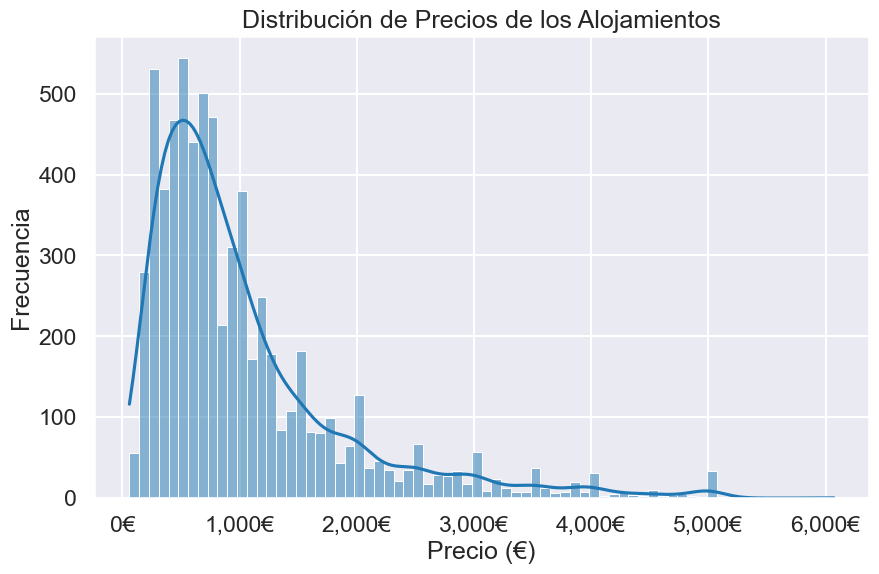

In [190]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True) #, color='blue')
plt.title('Distribución de Precios de los Alojamientos')
plt.xlabel('Precio (€)')
plt.ylabel('Frecuencia')
# Aplicar el formatter al eje X para mostrar el símbolo €
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

##### 003-1 Distribución de Precios por Ciudad
    El precio puede variar dependiendo de la ubicación, y es importante identificar si hay ciudades más rentables que otras.

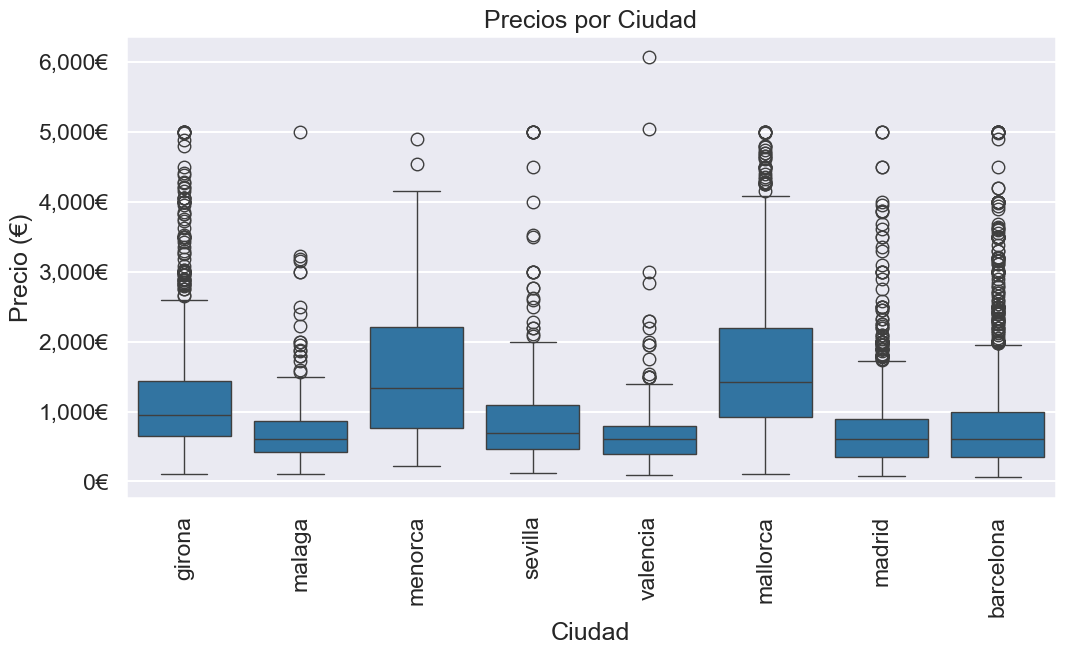

In [191]:
# Boxplot de precios por ciudad
plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='price', data=df)
plt.title('Precios por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Precio (€)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.xticks(rotation=90)
plt.show()

##### 003-2 Distribución de Precios por Tipo de Alojamiento
    El tipo de alojamiento también afecta la estrategia de precios

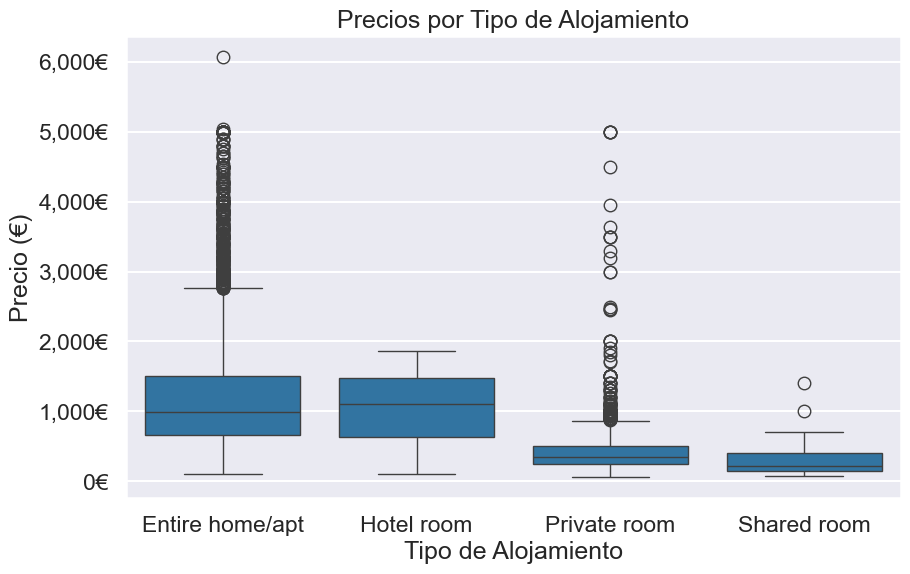

In [192]:
# Boxplot de precios por tipo de alojamiento
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=df)
plt.title('Precios por Tipo de Alojamiento')
plt.xlabel('Tipo de Alojamiento')
plt.ylabel('Precio (€)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

#### 003-3 Distribución de Precios por Número de Camas

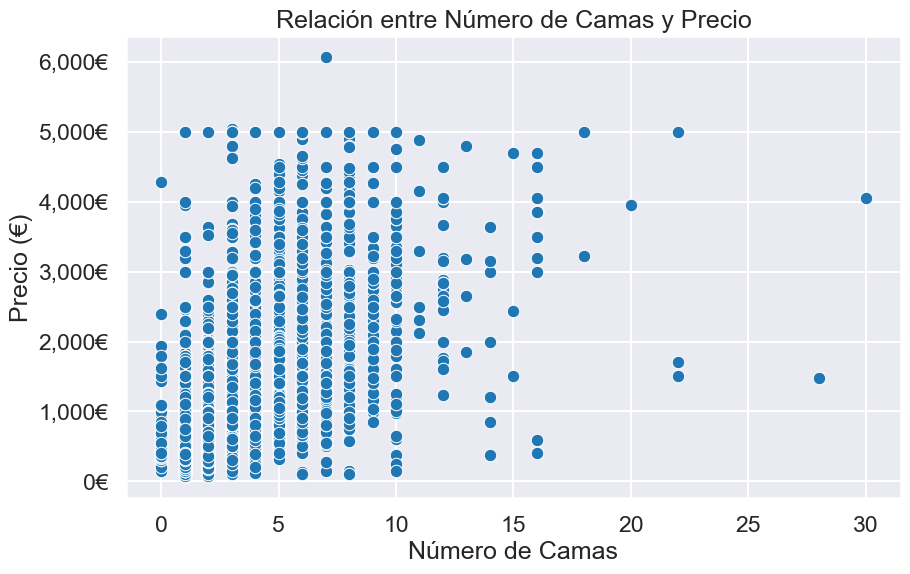

In [193]:
# Relación entre el número de camas y el precio
plt.figure(figsize=(10, 6))
sns.scatterplot(x='beds', y='price', data=df)
plt.title('Relación entre Número de Camas y Precio')
plt.xlabel('Número de Camas')
plt.ylabel('Precio (€)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

#### 003-4 Distribución de Precios por Número de Habitaciones

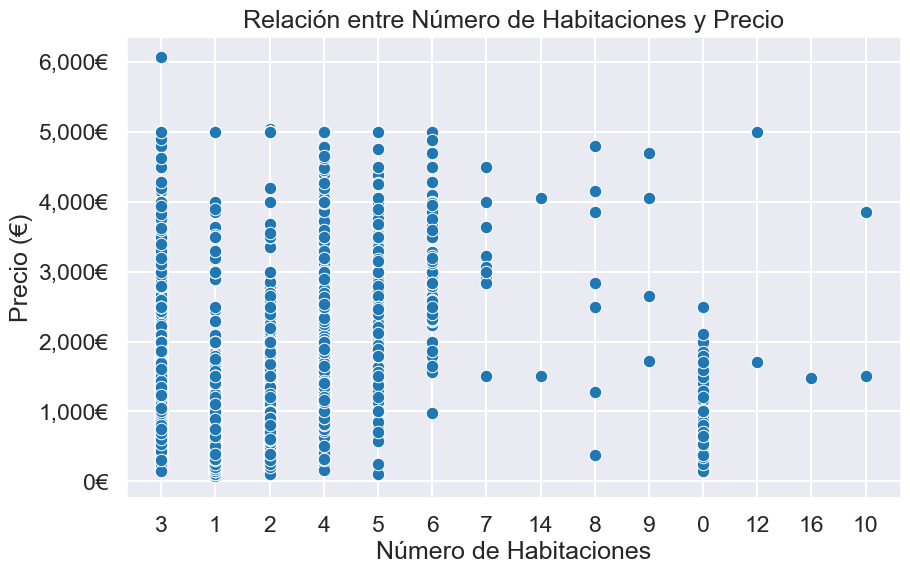

In [194]:
# Relación entre el número de habitaciones y el precio
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bedrooms', y='price', data=df)
plt.title('Relación entre Número de Habitaciones y Precio')
plt.xlabel('Número de Habitaciones')
plt.ylabel('Precio (€)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

### 004 Disponibilidad y Estrategias de Marketing
    La disponibilidad es clave, ya que si un alojamiento está constantemente lleno, su visibilidad y estrategias de marketing podrían necesitar ajustes. Además, el análisis de la reserva instantánea también es crucial para optimizar las tasas de conversión.

##### 004-1 Distribución de Disponibilidad en 30 días

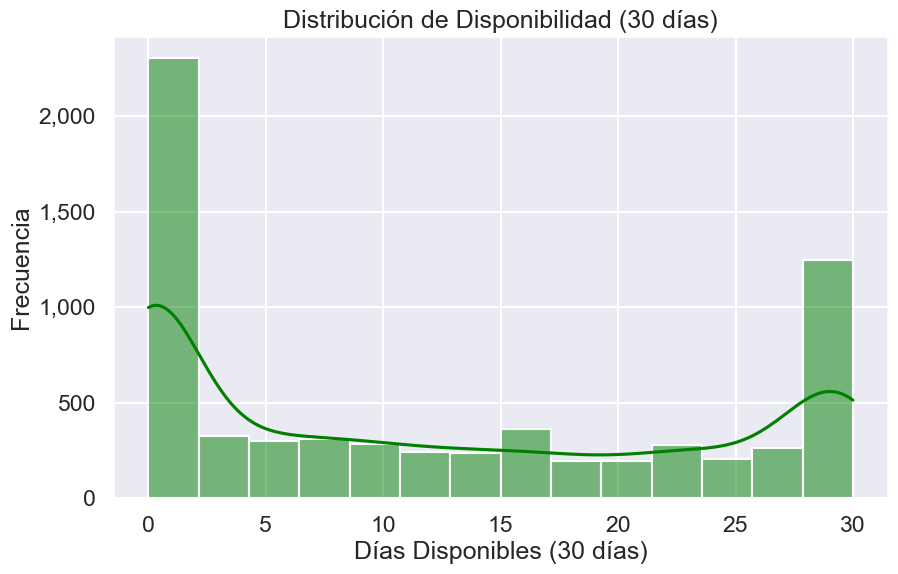

In [195]:
# Histograma de disponibilidad
plt.figure(figsize=(10, 6))
sns.histplot(df['availability_30'], kde=True, color='green')

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.title('Distribución de Disponibilidad (30 días)')
plt.xlabel('Días Disponibles (30 días)')
plt.ylabel('Frecuencia')
plt.show()

##### 004-2 Distribución de Disponibilidad en 60 días

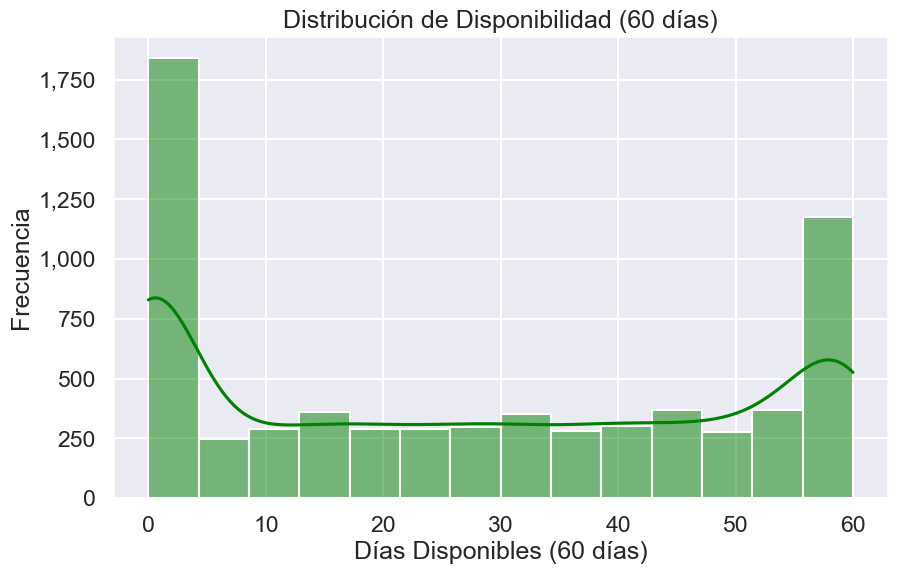

In [196]:
# Histograma de disponibilidad
plt.figure(figsize=(10, 6))
sns.histplot(df['availability_60'], kde=True, color='green')

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.title('Distribución de Disponibilidad (60 días)')
plt.xlabel('Días Disponibles (60 días)')
plt.ylabel('Frecuencia')
plt.show()

##### 004-3 Distribución de Disponibilidad en 90 días

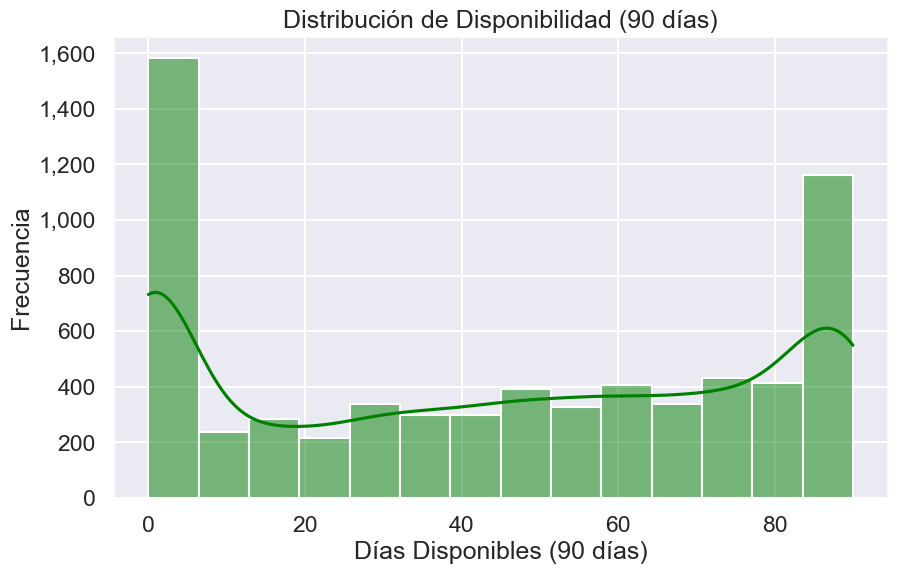

In [197]:
# Histograma de disponibilidad
plt.figure(figsize=(10, 6))
sns.histplot(df['availability_90'], kde=True, color='green')

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.title('Distribución de Disponibilidad (90 días)')
plt.xlabel('Días Disponibles (90 días)')
plt.ylabel('Frecuencia')
plt.show()

##### 004-4 Distribución de Disponibilidad en 365 días

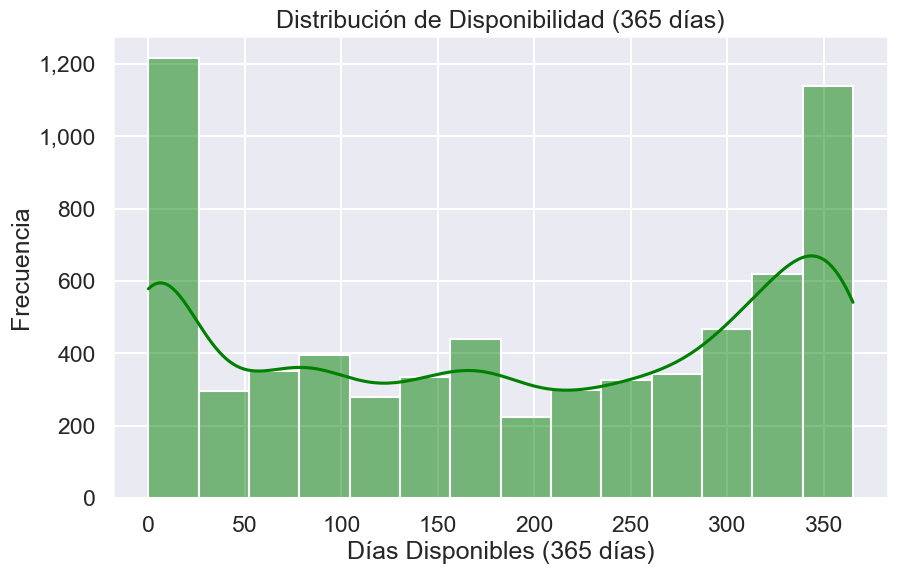

In [198]:
# Histograma de disponibilidad
plt.figure(figsize=(10, 6))
sns.histplot(df['availability_365'], kde=True, color='green')

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.title('Distribución de Disponibilidad (365 días)')
plt.xlabel('Días Disponibles (365 días)')
plt.ylabel('Frecuencia')
plt.show()

### 005 Reserva Instantánea y Comunicación
    Verificar cuántos alojamientos permiten la reserva instantánea.
    La reserva instantánea es un factor clave en la experiencia del usuario. Si la mayoría de los alojamientos tienen esta opción, se puede centrar la comunicación en la conveniencia y rapidez del proceso.

#### 005-1 Ver el porcentaje de alojamientos con reserva instantánea

In [199]:
instant_bookable_percentage = df['is_instant_bookable'].value_counts(normalize=True) * 100
print(instant_bookable_percentage)

is_instant_bookable
VERDADERO    53.24521
FALSO        46.75479
Name: proportion, dtype: float64


#### 005-2 Gráfico de la distribución de alojamientos con reserva instantánea

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18572\1596701451.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_instant_bookable', data=df, palette='viridis')


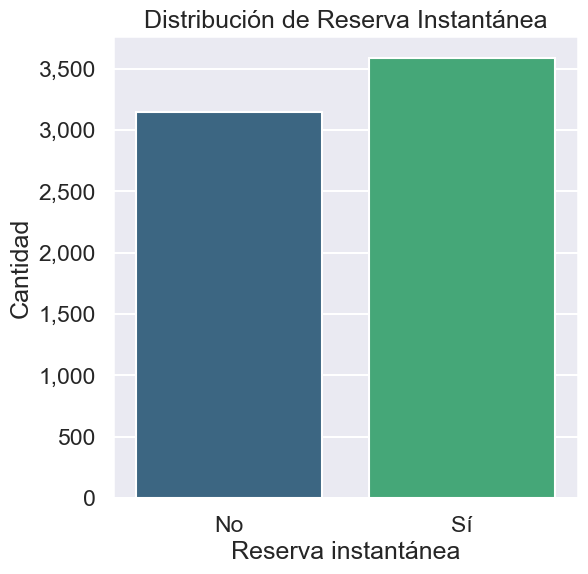

In [200]:
plt.figure(figsize=(6, 6))
sns.countplot(x='is_instant_bookable', data=df, palette='viridis')

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.xlabel('Reserva instantánea')
plt.ylabel('Cantidad')
plt.title('Distribución de Reserva Instantánea')
plt.xticks([0, 1], ['No', 'Sí'])
plt.show()

### 006 Análisis de Reseñas
    Las reseñas son un factor determinante en la decisión del cliente. Vamos a analizar tanto la cantidad de reseñas como la puntuación.

#### 006-1 Número de Reseñas y Puntuaciones
    La cantidad de reseñas y la puntuación promedio pueden indicar la popularidad y calidad de los alojamientos.

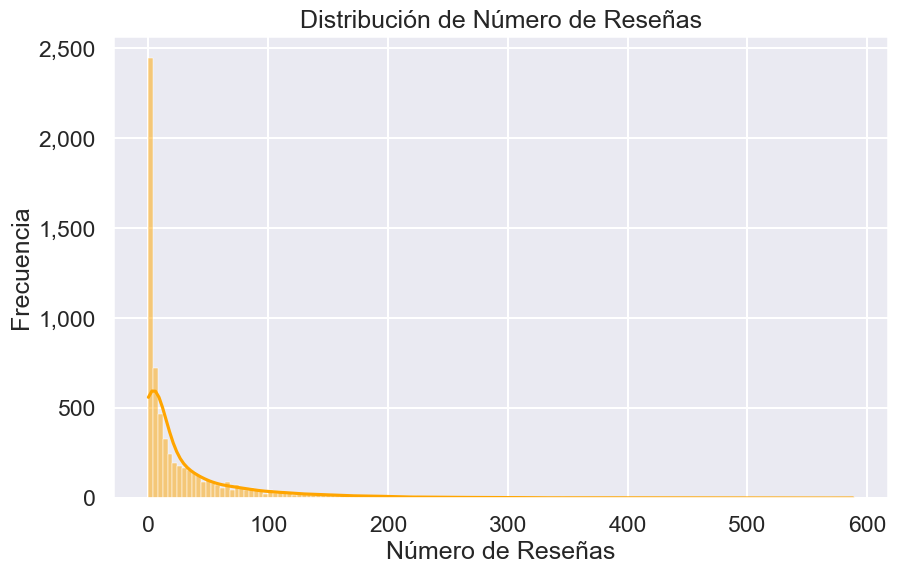

In [201]:
# Histograma de número de reseñas
plt.figure(figsize=(10, 6))
sns.histplot(df['number_of_reviews'], kde=True, color='orange')

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.title('Distribución de Número de Reseñas')
plt.xlabel('Número de Reseñas')
plt.ylabel('Frecuencia')
plt.show()

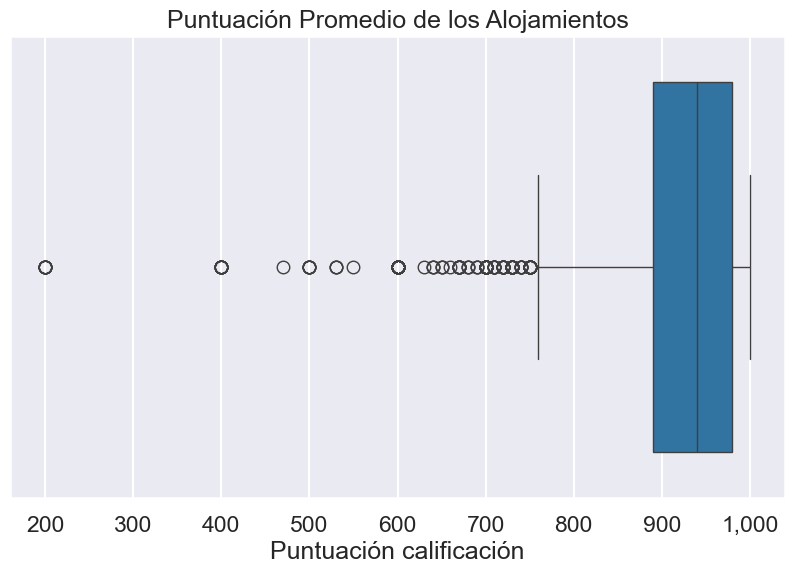

In [202]:
 # Boxplot de puntuaciones
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_scores_rating', data=df)

plt.gca().xaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.xlabel('Puntuación calificación')
plt.title('Puntuación Promedio de los Alojamientos')
plt.show()

#### 006-2 Puntuaciones por Tipo de Alojamiento

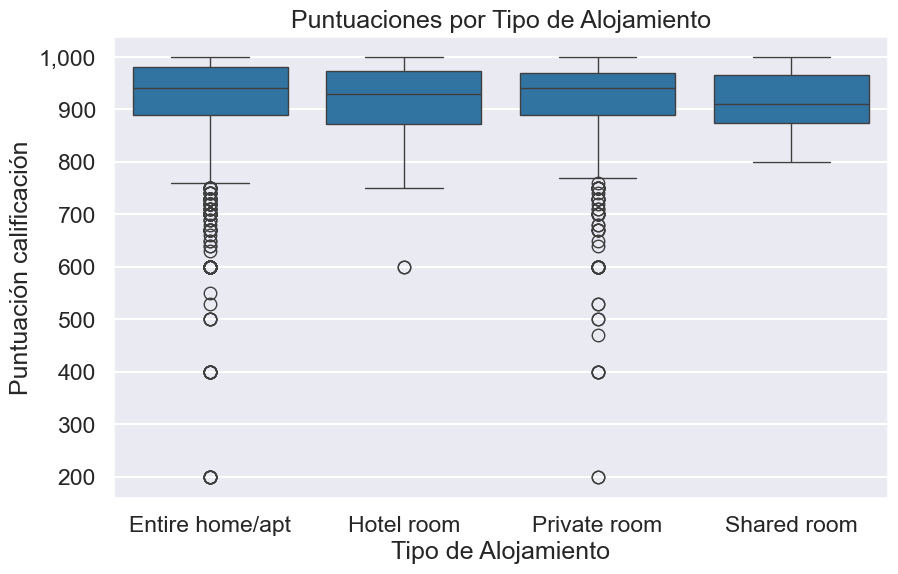

In [203]:
# Boxplot de puntuaciones por tipo de alojamiento
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='review_scores_rating', data=df)

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.xlabel('Tipo de Alojamiento')
plt.ylabel('Puntuación calificación')
plt.title('Puntuaciones por Tipo de Alojamiento')
plt.show()

In [204]:
availability_cols = ['availability_30', 'availability_60', 'availability_90', 'availability_365']

# Creamos una pivot table con 'city' como índice, aplicando la función mean para cada columna
availability_matrix = df.pivot_table(
    index='city',
    values=availability_cols,
    aggfunc='mean'
)

print(availability_matrix)

           availability_30  availability_365  availability_60  availability_90
city                                                                          
barcelona        11.073983        183.025968        25.596766        42.506124
girona           14.517972        195.765899        31.229493        48.352074
madrid           10.380372        163.906877        24.081662        39.886819
malaga           12.147493        201.702065        28.501475        47.197640
mallorca         13.304745        210.710766        28.593066        45.093066
menorca          14.956522        200.057971        30.782609        47.659420
sevilla          13.835777        200.384164        30.516129        49.721408
valencia         13.488215        183.067340        29.558923        47.565657


In [205]:
df.to_csv("df.csv")

RESPUESTA OPERACIONES 1/2

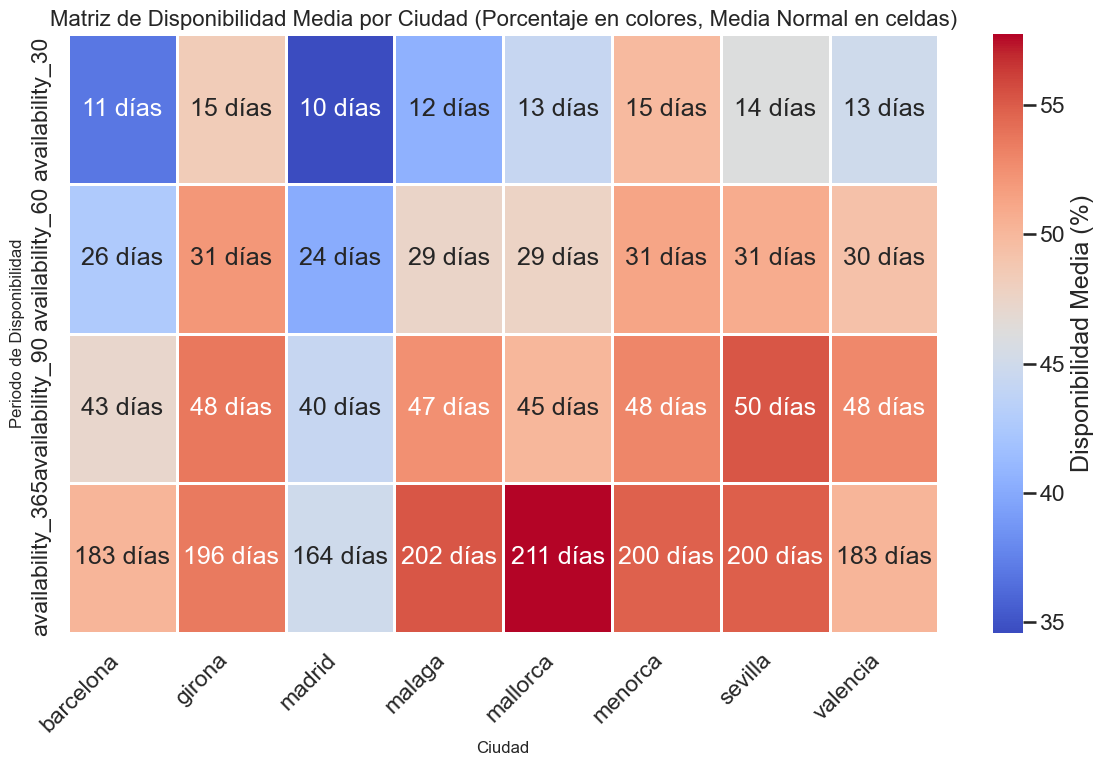

In [206]:
def grafico_matriz_disponibilidad(disponibilidad_media, disponibilidad_media_porcentaje):
    plt.figure(figsize=(12, 8)) 
    
    matrix_combined = disponibilidad_media_porcentaje.copy()

    annotaciones = disponibilidad_media.T.apply(lambda x: x.map(lambda v: f"{round(v)} días"))
    
    sns.heatmap(matrix_combined.T, annot=annotaciones.values, fmt="", cmap='coolwarm', cbar_kws={'label': 'Disponibilidad Media (%)'}, linewidths=1)
    
    plt.title('Matriz de Disponibilidad Media por Ciudad (Porcentaje en colores, Media Normal en celdas)', fontsize=16)
    plt.xlabel('Ciudad', fontsize=12)
    plt.ylabel('Periodo de Disponibilidad', fontsize=12)
    plt.xticks(rotation=45, ha='right')  
    
    plt.tight_layout()
    plt.show()



grafico_matriz_disponibilidad(disponibilidad_media, disponibilidad_media_porcentaje)

RESPUESTA OPERACIONES 2/2

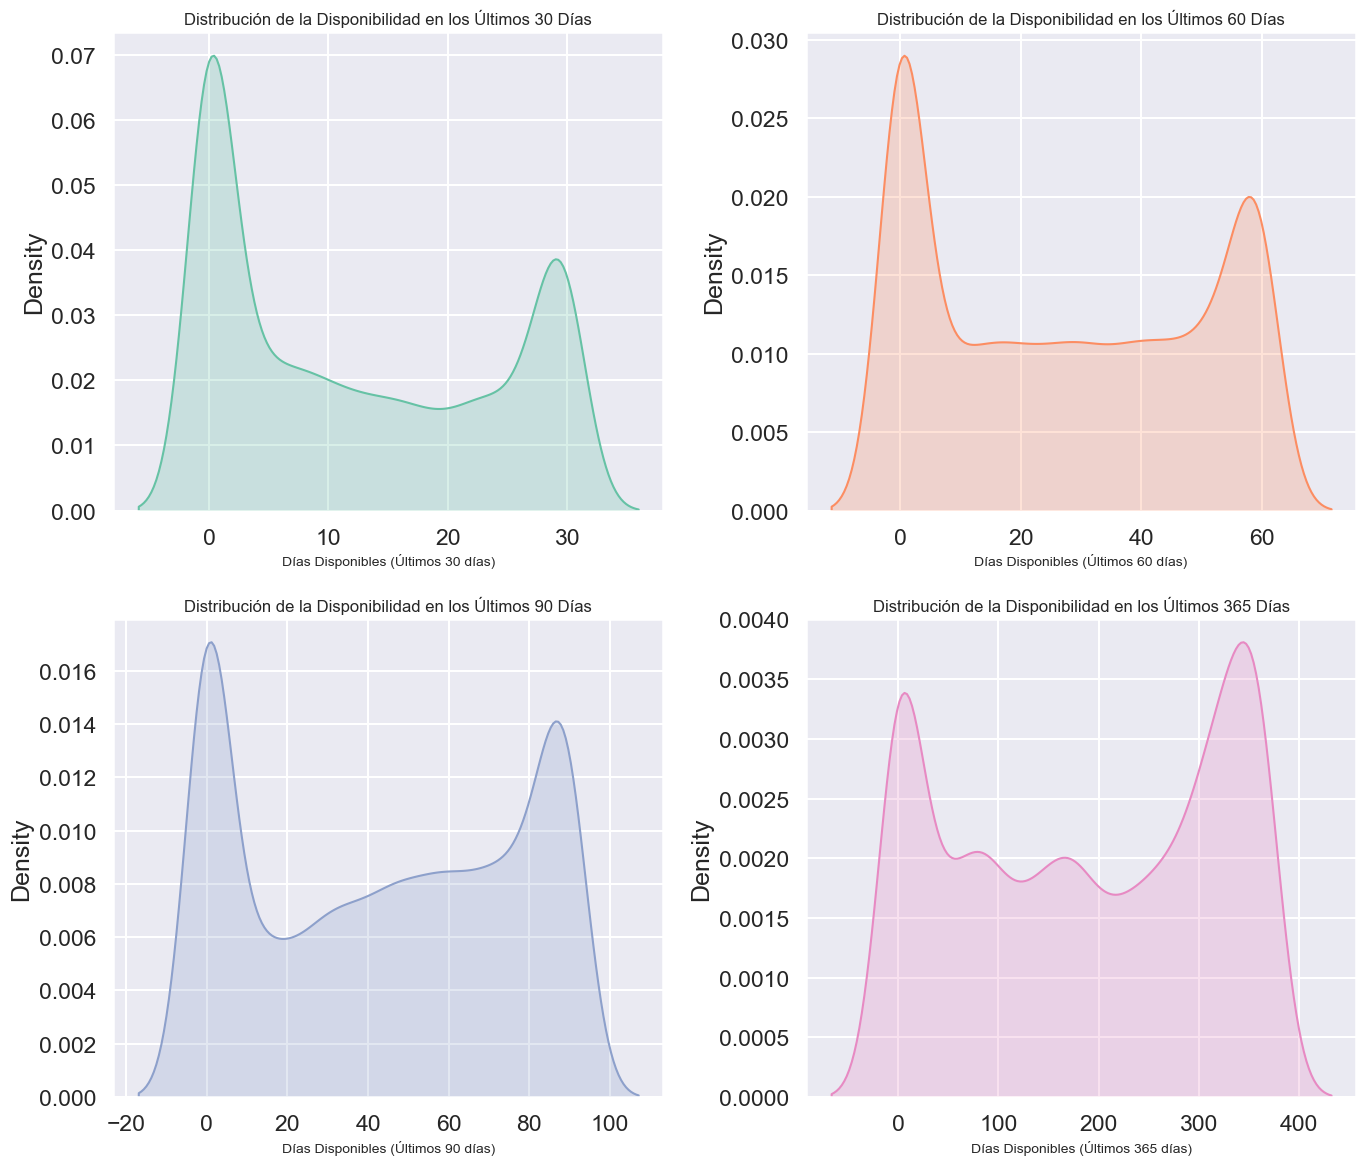

In [207]:
def distribucion_disponibilidad_kde(df, colores):
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))

    periodos = ['30', '60', '90', '365']
    disponibilidades = [df['availability_30'], df['availability_60'], df['availability_90'], df['availability_365']]

    for i, (periodo, disponibilidad) in enumerate(zip(periodos, disponibilidades)):
        fila = i // 2
        columna = i % 2
        sns.kdeplot(disponibilidad, fill=True, color=colores[i], ax=ax[fila, columna]) 

        ax[fila, columna].set_title(f'Distribución de la Disponibilidad en los Últimos {periodo} Días', fontsize=12)
        ax[fila, columna].set_xlabel(f'Días Disponibles (Últimos {periodo} días)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
distribucion_disponibilidad_kde(df, colores)
